In [1]:
%load_ext autoreload
%autoreload 2

# Notas generales de Sentiment Analysis

## Introducción

Introducción al tema...

## Problemas a tener en cuenta

* En los reviews de productos suele haber una tendencia al sesgo de los comentarios positivos (p 100 P&L)

* P&L recomiendan extraer las frases subjetivas y no incluir las objetivas pero yo creo que eso es hacer un poco de trampa.

* Una posibilidad es seleccionar por tópicos o tipos de productos

* Podría considerarse el problema de resumen de sentimientos, además de la categorización, y para eso usar el título del review.

* Considerar diferentes momentos para obtener los reviews [ver](https://www.aaai.org/Papers/Symposia/Spring/2004/SS-04-07/SS04-07-003.pdf) 


## TO DO list:

* Armar el datasheet del dataset MeLiSA e ir definiendo las características del mismo a partir de éste. Para eso, sería recomendable leer P&L, el paper de IMDb y el paper de datasheets for datasets

* Ver la [clase de sesgos en NLP](https://www.youtube.com/watch?v=XR8YSRcuVLE&feature=youtu.be) y las de evaluation metrics [1](https://youtu.be/3UGti9Ju5j8) y [2](https://youtu.be/YygGzfkhtJc) y estudiarlas bien bien.

* Analizar los posibles sesgos del dataset y modificar el datasheet del primer punto hasta que quede bien armado.

* Ir armando el paper. Tratar de separar las tareas para darle cosas para hacer a Mati y a Leo.

# Resumen cap 3, 4 y 5 de Pang & Lee

## Capítulo 3: Desafíos generales

El capítulo habla de por qué las tarea de clasificación de sentimientos es distinta a la de clasificación de texto en general. Se argumenta que extraer palabras relacionadas con el significado o la connotación (positiva o negativa) no es un gran indicativo de si el documento pertenece a una categoría determinada, debido a que los sentimientos pueden expresarse de manera mucho más sutil que simplemente explicitando una palabra clave y a que las oraciones suelen ser muy dependientes del contexto. Además el orden en que se dicen las cosas importan mucho.

Como ejercicio podemos probar clasificar texto con NaiveBayes+BOW y con LogisticRegression+BODocs:

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import torch

# Utilizo el dataset IMDb
ds, ds_info = tfds.load('imdb_reviews',
                        split=None, # Descargo todos los splits
                        download=True, # Si no está descargado, que se descargue
                        with_info=True, # Quiero que devuelva info del dataset
                       )

# Decodifico a dataframes con strings comunes
df_train = tfds.as_dataframe(ds['train'], ds_info)
df_train['text'] = df_train['text'].str.decode('utf-8')
df_test = tfds.as_dataframe(ds['test'], ds_info)
df_test['text'] = df_test['text'].str.decode('utf-8')

# Divido en train, val, test 
random_seed = 16254872
rs = np.random.RandomState(random_seed)
val_size = .1
mask = rs.rand(len(df_train)) < val_size
df_val = df_train[mask].copy().reset_index(drop=True)
df_train = df_train[~mask].copy().reset_index(drop=True)

# Tokenizo
df_train['text'] = df_train['text'].str.findall(r'[a-zA-Z0-9]+')
df_val['text'] = df_val['text'].str.findall(r'[a-zA-Z0-9]+')
df_test['text'] = df_test['text'].str.findall(r'[a-zA-Z0-9]+')

# Obtengo el vocabulario
vocab = df_train['text'].explode().value_counts()

In [2]:
print('Cantidad de palabras:',len(vocab))

Cantidad de palabras: 89356


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from nlp_feature_extraction import BONgramsVectorizer
from luthiertext import BONgramsVectorizer as BON2
import time

# Vectorizo los sets de train, val y test
tic = time.time()
# vec = CountVectorizer(analyzer= lambda x: x, vocabulary=vocab.index.tolist()[2:50000])
vec = CountVectorizer(analyzer = lambda x: x, max_features=50000)
X_train = vec.fit_transform(df_train['text'])
X_val = vec.transform(df_val['text'])
X_test = vec.transform(df_test['text'])
toc = time.time()
print('Vectorizer sklearn:',toc - tic)

tic = time.time()
vec2 = BONgramsVectorizer(tokenizer=None,min_count=0,
                max_count=None,max_words=50000,ngram_range=(1,1))
X_train2 = vec2.fit_transform(df_train['text'])
X_val2 = vec2.transform(df_val['text'])
X_test2 = vec2.transform(df_test['text'])
toc = time.time()
print('Vectorizer 1:',toc - tic)

tic = time.time()
vec3 = BON2(tokenizer=None,min_count=0,
                max_count=None,max_words=50000,ngram_range=(1,1))
X_train3 = vec3.fit_transform(df_train['text'])
X_val3 = vec3.transform(df_val['text'])
X_test3 = vec3.transform(df_test['text'])
toc = time.time()
print('Vectorizer 2:',toc - tic)


y_train = df_train['label'].values.astype(np.float)
y_val = df_val['label'].values.astype(np.float)
y_test = df_test['label'].values.astype(np.float)

100%|██████████| 25000/25000 [00:08<00:00, 2992.58it/s]
Vectorizer 2: 20.17693829536438


Entrenamiento por Naive Bayes:

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

clf = MultinomialNB()
clf.fit(X_train,y_train)
y_val_pred = clf.predict(X_val)
val_score = f1_score(y_val,y_val_pred, average='macro')
print('F1-score con Naive Bayes sobre development: {:.4f}'.format(val_score))

F1-score con Naive Bayes sobre development: 0.8395


In [5]:
y_test_pred = clf.predict(X_test)
test_score = f1_score(y_test,y_test_pred, average='macro')
print('F1-score con Naive Bayes sobre test: {:.4f}'.format(test_score))

F1-score con Naive Bayes sobre test: 0.8103


Entrenamiento por Logistic Regression:

In [11]:
from luthiertext import WordByCategoryVectorizer

y_train = df_train['label'].values.astype(np.float)
y_val = df_val['label'].values.astype(np.float)
y_test = df_test['label'].values.astype(np.float)

vec = WordByCategoryVectorizer(tokenizer=lambda x: x, min_count=0.,
                                max_count=None, max_words=None, unk_token=None,
                                reweighting='ppmi')
vec.train(df_train['text'],y_train)
X_train = vec.vectorize_corpus(df_train['text'])
X_val = vec.vectorize_corpus(df_val['text'])
X_test = vec.vectorize_corpus(df_test['text'])

100%|██████████| 25000/25000 [00:02<00:00, 10581.09it/s]



            Accuracy on train: 0
            Accuracy on val: 0
            Loss value: 2.65391. Epochs 0/10. Batch 0/89.
            

            Accuracy on train: 0
            Accuracy on val: 0
            Loss value: 0.624956. Epochs 1/10. Batch 0/89.
            

            Accuracy on train: 0
            Accuracy on val: 0
            Loss value: 0.234662. Epochs 2/10. Batch 0/89.
            

            Accuracy on train: 0
            Accuracy on val: 0
            Loss value: 0.320688. Epochs 3/10. Batch 0/89.
            

            Accuracy on train: 0
            Accuracy on val: 0
            Loss value: 0.252912. Epochs 4/10. Batch 0/89.
            

            Accuracy on train: 0
            Accuracy on val: 0
            Loss value: 0.231753. Epochs 5/10. Batch 0/89.
            

            Accuracy on train: 0
            Accuracy on val: 0
            Loss value: 0.237168. Epochs 6/10. Batch 0/89.
            

            Accuracy on train: 0
        

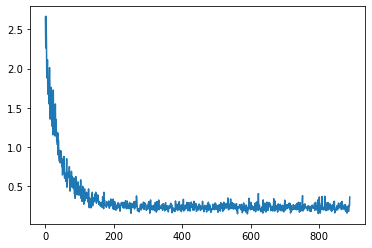

In [12]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


class IMDbDataset(Dataset):

    def __init__(self,X,y):
        self.X = torch.from_numpy(X).type(torch.float)
        self.y = torch.from_numpy(y).type(torch.float)

    def __getitem__(self,idx):
        return self.X[idx,:].view(-1),self.y[idx].view(-1)

    def __len__(self):
        return len(self.y)


train_dataset = IMDbDataset(X_train,y_train)
val_dataset = IMDbDataset(X_val,y_val)
test_dataset = IMDbDataset(X_test,y_test)

batch_size = 256
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)


# class LogisticRegressionClassifier(nn.Module):

#     def __init__(self,in_features,n_hidden,bias=True):
#         super().__init__()
#         self.linear = nn.Linear(in_features,n_hidden,bias=bias)
#         self.hidden = nn.Linear(n_hidden,1,bias=bias)

#     def forward(self,x):
#         logits = self.hidden(torch.relu(self.linear(x)))
#         return logits

class LogisticRegressionClassifier(nn.Module):

    def __init__(self,in_features,bias=True):
        super().__init__()
        self.linear = nn.Linear(in_features,1,bias=bias)

    def forward(self,x):
        logits = self.linear(x)
        return logits


epochs = 10
in_features = int(max(y_train)+1)
n_hidden = 20
#model = LogisticRegressionClassifier(in_features,n_hidden,bias=True)
model = LogisticRegressionClassifier(in_features,bias=True)
loss_fn = nn.BCEWithLogitsLoss()
loss_history = []
learning_rate = 5e-4
optim = torch.optim.SGD(model.parameters(), lr=learning_rate)
for e in range(epochs):
    for i, (x, y) in enumerate(train_dataloader):

        optim.zero_grad()

        logits = model(x)
        loss = loss_fn(logits,y)
        loss.backward()
        optim.step()
        
        loss_history.append(loss)

        if i % 100 == 0:
            print("""
            Accuracy on train: {}
            Accuracy on val: {}
            Loss value: {:4g}. Epochs {}/{}. Batch {}/{}.
            """.format(0,0,loss,e,epochs,i,len(train_dataloader)))
        

import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.show()

In [13]:
def predict(dataset,model):

    model.eval()

    n_samples = len(dataset)
    y_predict = torch.zeros(n_samples,dtype=torch.long)
    with torch.no_grad():
        for i in range(n_samples):
            x, _ = dataset[i]
            scores = model(x)
            y_predict[i] = (scores > 0).type(torch.long)

    return y_predict

from sklearn.metrics import f1_score

y_val_predict = predict(train_dataset,model)
val_score = f1_score(y_train,y_val_predict, average='macro')
print('F1-score con Logistic Regression sobre development: {:.4f}'.format(val_score))

F1-score con Logistic Regression sobre development: 0.9082


In [14]:
y_test_pred = predict(test_dataset,model)
test_score = f1_score(y_test,y_test_pred, average='macro')
print('F1-score con Logistic Regression sobre test: {:.4f}'.format(test_score))

F1-score con Logistic Regression sobre test: 0.7954


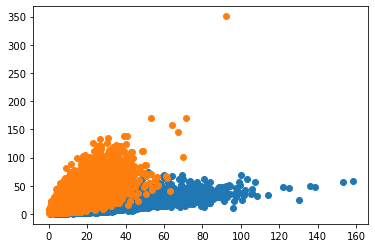

In [15]:
samples, labels = zip(*[train_dataset[i] for i in range(len(train_dataset))])

samples = torch.stack(samples,dim=0)
labels = torch.stack(labels,dim=0)

fig, ax = plt.subplots()
ax.plot(samples[(labels==0).view(-1),0],samples[(labels==0).view(-1),1],'o')
ax.plot(samples[(labels==1).view(-1),0],samples[(labels==1).view(-1),1],'o')

## Capítulo 4: Clasificación y Extracción

Este capítulo tiene varias partes.

### Parte I: Fundamentals

En esta parte va a hablar de las diferentes tareas que se pueden resolver en análisis de sentimientos cuando se trata el problema como clasificación. 

* **Polarización**: Cuando se modeliza un problema de clasificación de sentimientos binaria (positiva o negativa), se habla de "clasificación de polaridad". Si bien, el caso prototípico de esta forma de clasificar es con reviews (like vs dislike), existen formas de polarización más subjetivas ("a favor" vs "en contra" en un debate político, o "optimista" vs "pesimista" en una nota periodística, por ejemplo). La dificultad en estos casos reside en que es muy debatible el grado de positividad o negatividad de las muestras que se dispone y esto condiciona la clasificación entera.

* **Categorías relacionadas**: Un problema de extracción-clasificación muy importante es el de extraer del texto las partes que justifican la elección del comentario como positivo o negativo. Por ejemplo en un review, se extraen los comentarios y se clasifican en "pro" vs "con". 

* **Regresión en opiniones**: Cuando se hace clasificación de muchas categorías en sentimientos también se suele plantear como un problema de regresión debido a que las categorías son intrínsecamente ordenadas. Un tema a tener en cuenta es la separación en el grado de seguridad de los comentarios y el valor del comentario (uno puede estar muy seguro de su postura, sea positiva, mediocre o negativa)




# CLase de sesgos en AI

Lo primero que menciona es la "teoría prototípica", una hipótesis que plantea (dicho mal y pronto) que en el mundo hay objetos que representan mejor ciertas categorías que otros, y de que hay un "prototipo" de las cosas. Esto da a pensar que hay una noción de lo que est típico y atípico en los textos que encontramos en internet y de que quizás la frecuencia de las palabras no son indicio de cuán frecuentes son en el texto sino de cuán frecuente las tendemos a mencionar o cuán importante son para nosotros.

Otra cosa importante es que los datos en sí ya están sesgados, independientemente de cómo se recolecten.

Hay varias cosas que menciona en el medio, pero cuando llega a la parte de los datos, dice que es muy importante tener un test set que incluya los casos en que es bastante problemático no clasificar bien. 